In [10]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import pickle
import matplotlib.pyplot as plt
from keras.preprocessing import image

Using TensorFlow backend.


In [20]:
gt = pickle.load(open('../pkls/SUNRGBD/RGB.pkl', 'rb'))
#gt = pickle.load(open('../pkls/SUNRGBD/RGB.pkl', 'rb'))
keys = sorted(gt.keys())


../dataset/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/image/0000103.jpg


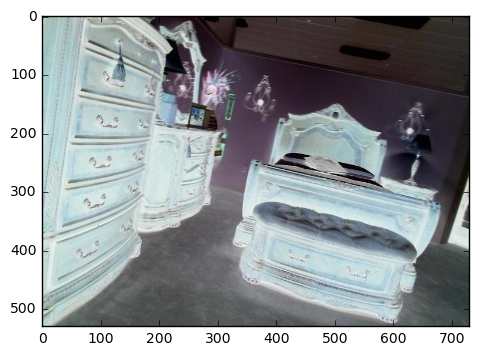

In [22]:
path_prefix = '../dataset/SUNRGBD/kv2/kinect2data/'
img_path = path_prefix + sorted(keys)[0]
print(img_path)
img = image.load_img(img_path)
img = image.img_to_array(img)
plt.imshow(img)

In [47]:
array = gt['000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/image/0000103.jpg'][3]
print(array)

[ 157.75919732   10.63545151  156.8729097   362.4916388     0.            0.
    0.            1.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.        ]


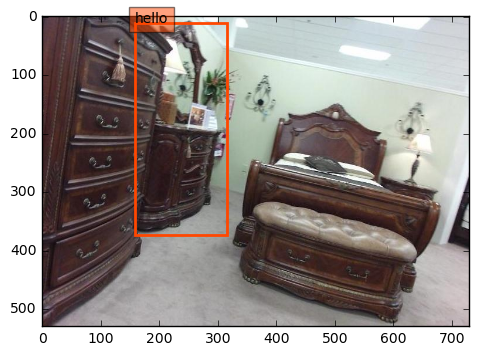

In [48]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
currentAxis = plt.gca()
plt.imshow(img / 255.)
xmin = int(round(array[0])) 
ymin = int(round(array[1]))
xmax = int(round(array[2])) + xmin
ymax = int(round(array[3])) + ymin
coords = (xmin, ymin), xmax - xmin +1, ymax - ymin+1
color = colors[1]
currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
currentAxis.text(xmin, ymin, 'hello', bbox={'facecolor':color, 'alpha':0.5})
plt.show()